<a href="https://colab.research.google.com/github/therishabhmittal-05/NN-Ninja/blob/main/MiniGrad/minigrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## minigrad is Scaler Value Autograd Engine

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [4]:
def f(x):
  return 3*x**2 + 4*x + 2

In [5]:
f(3.0)

41.0

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([57.    , 50.6875, 44.75  , 39.1875, 34.    , 29.1875, 24.75  ,
       20.6875, 17.    , 13.6875, 10.75  ,  8.1875,  6.    ,  4.1875,
        2.75  ,  1.6875,  1.    ,  0.6875,  0.75  ,  1.1875,  2.    ,
        3.1875,  4.75  ,  6.6875,  9.    , 11.6875, 14.75  , 18.1875,
       22.    , 26.1875, 30.75  , 35.6875, 41.    , 46.6875, 52.75  ,
       59.1875, 66.    , 73.1875, 80.75  , 88.6875])

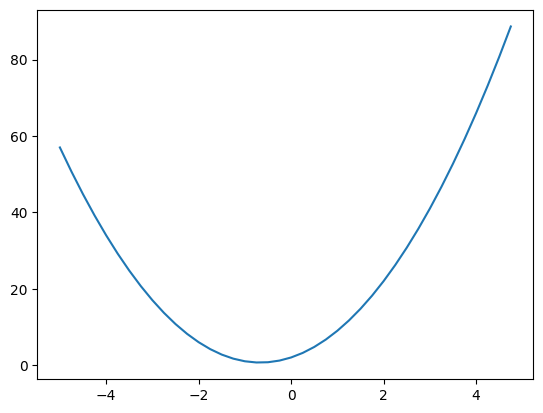

In [7]:
plt.plot(xs, ys)
plt.show()

In [8]:
h = 0.00001
x = 3.0
(f(x+h)-f(x))/h

22.000029999702516

In [9]:
a = 2.0
b = 3.0
c = 0.1
d = a*b + c
print(d)

6.1


In [10]:
h = 0.0001
a = 2.0
b = 3.0
c = 0.1

d1 = a*b + c
print('d1', d1)

c += h
d2 = a*b+c
print('d2', d2)
print('slope', (d2-d1)/h)

d1 6.1
d2 6.1001
slope 1.0000000000065512


In [140]:
class Value:
  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.grad = 0
    self.label = label
    self._backward =  lambda: None

  def __repr__(self):
    return f"Value(data = {self.data})"


  def __add__(self, other ):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1 * out.grad
      other.grad += 1 * out.grad
    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self,), f"**{other}")
    def _backward():
      self.grad += (other * self.data**(other-1))* out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other ** -1

  def exp(self):
    out = Value(math.exp(self.data), (self,), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self,), 'tanh')
    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [141]:
a = Value(2.0, label = 'a')
2*a

Value(data = 4.0)

In [87]:
from graphviz import Digraph
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
  assert rankdir in ['LR', 'TB']
  nodes, edges = trace(root)
  dot = Digraph(format=format, graph_attr={'rankdir': rankdir})

  for n in nodes:
    dot.node(name=str(id(n)), label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name=str(id(n)) + n._op, label=n._op)
      dot.edge(str(id(n))+n._op, str(id(n)))
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

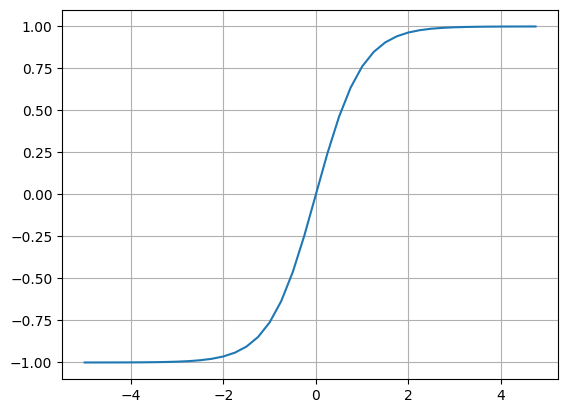

In [65]:
plt.plot(np.arange(-5.0, 5.0, 0.25), np.tanh(np.arange(-5.0, 5.0, 0.25))); plt.grid()

In [119]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

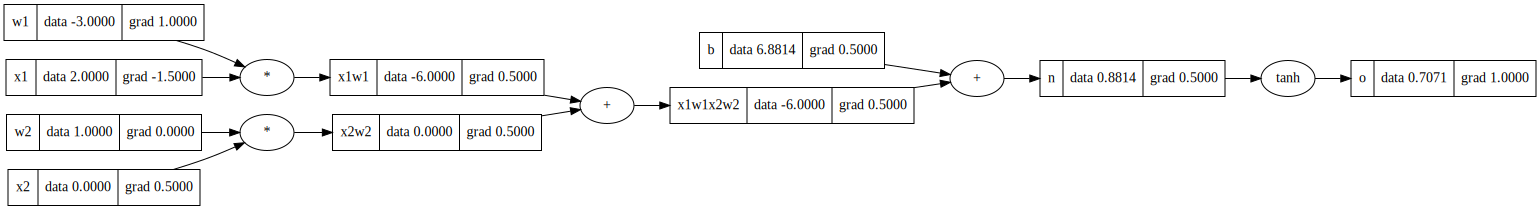

In [122]:
draw_dot(o)

In [147]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1);  o.label = 'o'
o.backward()

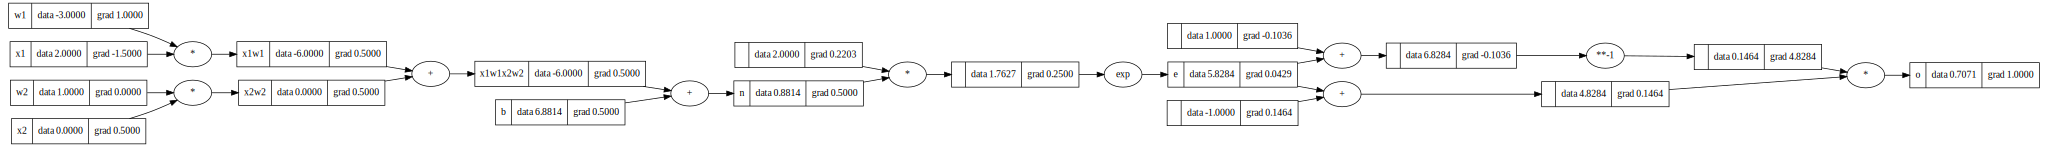

In [148]:
draw_dot(o)

In [157]:
import random
class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))
  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    return act.tanh()
n = Neuron(2)
x = [2.0, 3.0]
n(x)

Value(data = -0.6620221489141664)